In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
import joblib
from tqdm.notebook import tqdm

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time

In [4]:
def data_preparation(X, y, c=10000, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = c
    count1 = c

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))

    data = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
    np.random.shuffle(data)

    datat = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
    np.random.shuffle(datat)
    

    return data, datat

In [5]:
def scor(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'min_child_samples':hp.randint('min_child_samples', 80)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    #'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'bagging_freq':     hp.randint('bagging_freq', 20),
    'n_estimators':     1000
}
lgb_fit_params = {
    'early_stopping_rounds': 50,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [6]:
def F1_plot_class(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column, file_name=None, N=5):
    def F1(y_true, y_pred):
        from sklearn import metrics
        return metrics.f1_score(y_true, y_pred, average=None)
    acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, F1, lit= 50 if N < 6 else 100)
    acc = np.array(acc).T
    plt.figure(figsize=(10, 10))
    lab =['S', 'Q', 'G']
    lines = []
    labels = []
    clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',    'lightskyblue']
    for j in range(3):
        l, = plt.plot(r, acc[j], color=clr[j], lw=2)
        lines.append(l)
        labels.append(lab[j])


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel(column)
    #plt.xlim(11, 20)
    plt.ylim(0.5, 1.01)
    plt.ylabel('F1')
    plt.title('F1')
    plt.grid(True)
    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
    if file_name is not None:
        plt.savefig(file_name+'F1.png')
    plt.show()

In [7]:
def Recall_plot_class(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column, file_name=None, N=5):
    def recall(y_true, y_pred):
        from sklearn import metrics
        return metrics.recall_score(y_true, y_pred, average=None)
    acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, recall, lit= 50 if N < 6 else 100)
    acc = np.array(acc).T
    plt.figure(figsize=(10, 10))
    lab =['S', 'Q', 'G']
    lines = []
    labels = []
    clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',    'lightskyblue']
    for j in range(3):
        l, = plt.plot(r, acc[j], color=clr[j], lw=2)
        lines.append(l)
        labels.append(lab[j])


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel(column)
    #plt.xlim(11, 20)
    plt.ylim(0.5, 1.01)
    plt.ylabel('recall')
    plt.title('recall')
    plt.grid(True)
    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
    if file_name is not None:
        plt.savefig(file_name+'recall.png')
    plt.show()

In [8]:
def Prediction_Recall_plot(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column, file_name=None, N=4):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    classes = {1: 'S', 2: 'Q', 3: 'G'}

    def Pres_Rec(y_true, y_pred_proba):
        classes = [1, 2, 3]
        Y = label_binarize(y_true, classes=classes)
        precision, recall, _ = precision_recall_curve(Y.ravel(), 
                                                                                                    y_pred_proba.ravel())     
        return [precision, recall]

    def Pres_Rec_class(y_true, y_pred_proba):
        classes = [1, 2, 3]
        Y = label_binarize(y_true, classes=classes)
        precision, recall = dict(), dict()
        for i in classes:
            precision[i], recall[i], _ = precision_recall_curve(Y[:, i-1],
                                                                                                                    y_pred_proba[:, i-1])    
        return [precision, recall]

    
    acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, function=Pres_Rec, proba=True, lit= 50 if N < 6 else 100)

    if (N==1) and (file_name is not None):
        acc = np.array(acc)
        np.savetxt(file_name+'Precision_Recall_micro.txt', acc[0])

    plt.figure(figsize=(10, 10))
    lab = r
    lines = []
    labels = []
    clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',    'lightskyblue']
    for j, r_bin in enumerate(lab):
        l, = plt.plot(acc[j][1], acc[j][0], color=clr[j], lw=2)
        lines.append(l)
        labels.append(f"{column} = {r_bin}")


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall micro')
    plt.grid(True)
    #plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
    if file_name is not None:
        plt.savefig(file_name+'Precision_Recall_micro.png')
    plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
    if file_name is not None:
        plt.savefig(file_name+'Precision_Recall_micro_legend.png')
    plt.show()
    
    
    acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, function=Pres_Rec_class, proba=True, lit= 50 if N < 6 else 100)
    if (N==1) and (file_name is not None):
        acc = np.array(acc)
        for i in range(1, 4):
            np.savetxt(file_name+f'Precision_Recall_{classes[i]}.txt', np.concatenate((np.array([acc[0, 0][i]]).T, np.array([acc[0, 1][i]]).T), axis=1))

    for i in range(1, 4):
        plt.figure(figsize=(10, 10))
        lab = r
        lines = []
        labels = []
        for j, r_bin in enumerate(lab):
            l, = plt.plot(acc[j][1][i], acc[j][0][i], color=clr[j], lw=2)
            lines.append(l)
            labels.append(f"{column} = {r_bin}")


        fig = plt.gcf()
        fig.subplots_adjust(bottom=0.25)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall for class {classes[i]}')
        plt.grid(True)

        if file_name is not None:
            plt.savefig(file_name+f'Precision_Recall_{classes[i]}.png')

        plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))

        if file_name is not None:
            plt.savefig(file_name+f'Precision_Recall_{classes[i]}_legend.png')
        
        plt.show()

In [59]:
def Confusion_Matrix(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column=None, file_name=None, norm=False, one=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay


    y_test = np.concatenate((y2, y1)) if not one else y1
    y_pred = np.concatenate((gb1.predict(X2[:, 1:] if robust1 is None 
                                                                             else robust1.transform(X2[:, 1:])), 
                                                     gb2.predict(X1[:, 1:] if robust2 is None 
                                                                             else robust2.transform(X1[:, 1:])))) if not one else gb1.predict(X1[:, 1:] if robust1 is None else robust1.transform(X1[:, 1:]))



    cm = np.around(confusion_matrix(y_test, y_pred,    normalize='true' if norm else None), 3)
    print(cm)

    plt.clf()
    plt.imshow(cm, cmap='cool')#='Set3')
    classNames = ['S','Q','G']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    
    for i in range(3):
            for j in range(3):
                    plt.text(j,i,str(cm[i][j]), horizontalalignment='center', verticalalignment='center')
    if file_name is not None:
            print('saaaaaaaaaaaave')        
            plt.savefig(file_name+f'Confusion_Matrix.png' if not norm else file_name+f'norm_Confusion_Matrix.png')
    plt.show()

In [10]:
def scor(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'min_child_samples':hp.randint('min_child_samples', 80)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    #'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'bagging_freq':     hp.randint('bagging_freq', 20),
    'n_estimators':     1000
}
lgb_fit_params = {
    'early_stopping_rounds': 50,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [11]:
class HPOpt(object):

    def __init__(self, X, y, cv=3):
        self.X = X
        self.y = y
        self.cv = cv
        #print('init')

    def process(self, fn_name, space, trials, algo, max_evals):
        #print('in process')
        fn = getattr(self, fn_name)
        try:
            #print('try')
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
            #print('i can')
        except Exception as e:
            print({'status': STATUS_FAIL,
                    'exception': str(e)})
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        if self.cv>1:
            return self.train_cv_gb(reg, para)
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            #print('start')
            reg.fit(self.X, self.y,
                  eval_set=[(self.X, self.y), (self.X, self.y)],
                  **para['fit_params'])
        else:
            reg.fit(self.X, self.y)
        pred = reg.predict(self.X)
        loss = para['score'](self.y, pred)
        return {'loss': loss, 'status': STATUS_OK}


    def train_cv_gb(self, reg, para):
        kf = KFold(n_splits=self.cv, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            #print('start', type(train[0]), type(test[0]), type(self.y[0]), type(self.X))
            if len(para['fit_params'])>0:
                reg = lgb.LGBMClassifier(**para['reg_params'])
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            #print('pred')
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/self.cv
        return {'loss': loss, 'status': STATUS_OK}

In [12]:
def For_one_gb(X_train, y_train, mod, overview): #######################заменяем полностью
    robust = RobustScaler()
    
    data, datat = data_preparation(X_train, y_train, test_size=0.2)
    

    X_train , y_train = data[:, :-1], data[:, -1].astype('int')
    X_valid, y_valid = datat[:, :-1], datat[:, -1].astype('int')
    X_train_norm = robust.fit_transform(X_train)
    X_valid_norm = robust.transform(X_valid)
    
    

    obj = HPOpt(X_train_norm, y_train, cv=3)
    lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
    print(lgb_opt)
    gb = lgb.LGBMClassifier( 
                                **{'colsample_bytree': lgb_opt[0]['colsample_bytree'],
                                  'min_child_samples': lgb_opt[0]['min_child_samples']+1,
                                  #'min_child_weight': lgb_opt[0]['min_child_weight'],
                                  'num_leaves': lgb_opt[0]['num_leaves']+10,
                                  'bagging_freq':lgb_opt[0]['bagging_freq'],
                                  'n_estimators': 1000
                                  }
                              )
    t = time()
    gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)], **lgb_fit_params)
    joblib.dump(gb, './models_little/'+mod+'/model_'+overview+'.pkl')
    joblib.dump(robust, './models_little/'+mod+'/'+overview+'_robust_for_gb.pkl')

    print(time()-t)

    return gb, robust

In [56]:
features_path = '../../models_before_aggregation_j/features.pkl'
column = 'sdssdr16_r_cmodel'
j_features = ['J']
features = pd.read_pickle(features_path) + j_features

In [57]:
sdss_wise = [
                'sdssdr16_u_cmodel-decals8tr_Lw1',
                'sdssdr16_u_cmodel-decals8tr_Lw2',
                'sdssdr16_g_cmodel-decals8tr_Lw1',
                'sdssdr16_g_cmodel-decals8tr_Lw2',
                'sdssdr16_r_cmodel-decals8tr_Lw1',
                'sdssdr16_r_cmodel-decals8tr_Lw2',
                'sdssdr16_i_cmodel-decals8tr_Lw1',
                'sdssdr16_i_cmodel-decals8tr_Lw2',
                'sdssdr16_z_cmodel-decals8tr_Lw1',
                'sdssdr16_z_cmodel-decals8tr_Lw2' 
              ]
sdss_nwise = [
                'sdssdr16_g_cmodel-decals8tr_g',
                'sdssdr16_r_cmodel-decals8tr_r',
                'sdssdr16_z_cmodel-decals8tr_z'
]

ps_decals = [
                'psdr2_g_kron-decals8tr_Lw1',
                'psdr2_g_kron-decals8tr_Lw2',
                'psdr2_r_kron-decals8tr_Lw1',
                'psdr2_r_kron-decals8tr_Lw2',
                'psdr2_i_kron-decals8tr_Lw1',
                'psdr2_i_kron-decals8tr_Lw2',
                'psdr2_z_kron-decals8tr_Lw1',
                'psdr2_z_kron-decals8tr_Lw2',
                'psdr2_y_kron-decals8tr_Lw1',
                'psdr2_y_kron-decals8tr_Lw2'
]

sdss = [i for i in features if 'sdss' in i and 'decals' not in i and column not in i] 
decals = [i for i in features if 'decals' in i and 'sdss' not in i and 'psdr' not in i and column not in i] 
wise = [i for i in decals if 'Lw' in i and column not in i] 
ps = [i for i in features if 'psdr' in i and 'decals' not in i and column not in i]

f0 = {"sdssdr16+wise_decals8tr": sdss+wise+sdss_wise,
     "psdr2+wise_decals8tr": ps+wise+ps_decals,
     "sdssdr16+all_decals8tr": sdss+decals+sdss_wise+sdss_nwise,
     "psdr2+all_decals8tr": ps+decals+ps_decals,
     "decals8tr": decals,
     "sdssdr16+psdr2+wise_decals8tr": sdss+ps+wise+sdss_wise+ps_decals,
     "sdssdr16+psdr2+all_decals8tr": sdss+ps+decals+ps_decals+sdss_wise+sdss_nwise}

sdss_j = [
    'sdssdr16_u_psf-j',
     'sdssdr16_g_psf-j',
     'sdssdr16_r_psf-j',
     'sdssdr16_i_psf-j',
     'sdssdr16_z_psf-j',
     'sdssdr16_u_cmodel-j',
     'sdssdr16_i_cmodel-j'
]

ps_j = [
    'psdr2_i_kron-j',
     'psdr2_y_kron-j',
     'psdr2_g_psf-j',
     'psdr2_r_psf-j',
     'psdr2_i_psf-j',
     'psdr2_z_psf-j',
     'psdr2_y_psf-j'
]

wise_j = [
    'decals8tr_Lw1-j',
     'decals8tr_Lw2-j'
]

nwise_j = [
    'decals8tr_g-j',
     'decals8tr_r-j',
     'decals8tr_z-j'
]


l = [sdss_j, ps_j, wise_j, nwise_j]

f1 = {"sdssdr16+wise_decals8tr": sdss+wise+sdss_wise+sdss_j+wise_j+j_features,
     "psdr2+wise_decals8tr": ps+wise+ps_decals+ps_j+wise_j+j_features,
     "sdssdr16+all_decals8tr": sdss+decals+sdss_wise+sdss_nwise+sdss_j+wise_j+nwise_j+j_features,
     "psdr2+all_decals8tr": ps+decals+ps_decals+ps_j+wise_j+nwise_j+j_features,
     "decals8tr": decals+wise_j+nwise_j+j_features,
     "sdssdr16+psdr2+wise_decals8tr": sdss+ps+wise+sdss_wise+ps_decals+ps_j+wise_j+sdss_j+j_features,
     "sdssdr16+psdr2+all_decals8tr": sdss+ps+decals+ps_decals+sdss_wise+sdss_nwise+sdss_j+nwise_j+ps_j+wise_j+j_features}

f={'not_j': f0, 'j':f1}

In [27]:
f

{'not_j': {'sdssdr16+wise_decals8tr': ['sdssdr16_u_psf',
   'sdssdr16_g_psf',
   'sdssdr16_r_psf',
   'sdssdr16_i_psf',
   'sdssdr16_z_psf',
   'sdssdr16_u_cmodel',
   'sdssdr16_i_cmodel',
   'sdssdr16_u-g_psf',
   'sdssdr16_u-r_psf',
   'sdssdr16_u-i_psf',
   'sdssdr16_u-z_psf',
   'sdssdr16_u_psf-cmodel',
   'sdssdr16_g-i_psf',
   'sdssdr16_g_psf-cmodel',
   'sdssdr16_r-i_psf',
   'sdssdr16_i-z_psf',
   'sdssdr16_i_psf-cmodel',
   'decals8tr_Lw1-Lw2',
   'decals8tr_Lw1',
   'decals8tr_Lw2',
   'sdssdr16_u_cmodel-decals8tr_Lw1',
   'sdssdr16_u_cmodel-decals8tr_Lw2',
   'sdssdr16_g_cmodel-decals8tr_Lw1',
   'sdssdr16_g_cmodel-decals8tr_Lw2',
   'sdssdr16_r_cmodel-decals8tr_Lw1',
   'sdssdr16_r_cmodel-decals8tr_Lw2',
   'sdssdr16_i_cmodel-decals8tr_Lw1',
   'sdssdr16_i_cmodel-decals8tr_Lw2',
   'sdssdr16_z_cmodel-decals8tr_Lw1',
   'sdssdr16_z_cmodel-decals8tr_Lw2'],
  'psdr2+wise_decals8tr': ['psdr2_i_kron',
   'psdr2_y_kron',
   'psdr2_g_psf',
   'psdr2_r_psf',
   'psdr2_i_psf',
   'p

In [58]:
df = pd.read_pickle('./data/weak.pkl_gz', compression='gzip')#'./data/rename_x1_class.pkl_gz', compression='gzip')

In [ ]:
df1 = df.loc[df['fold'] == 0]
df2 = df.loc[df['fold'] == 1]

In [16]:
# ##############################
# accuracy = dict()
# brightness = dict()
# model = 'gb'

# data = 'j'

# import os
# path = f"./plots/{model}_on_{data}"

# try:
#         os.makedirs(path)
# except FileExistsError:
#     print("Директория %s уже существует" % path) 
# except OSError:
#         print ("Создать директорию %s не удалось" % path)
#         exit()

# for overview in f[data].keys():
#     path = f"./plots/{model}_on_{data}/{overview}"
#     try:
#             os.makedirs(path)
#     except FileExistsError:
#         print("Директория %s уже существует" % path)
#     except OSError:
#             print("Создать директорию %s не удалось" % path)
#             exit()

#     print(overview)
#     print([column]+f[data][overview])
    
    

#     X1, y1 = df1[[column]+f[data][overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
#     X2, y2 = df2[[column]+f[data][overview]].values, df2['class'].values


#     m = For_one_gb
#     model1, robust1 = m(X1[:, 1:], y1, data, overview)
#     model2, robust2 = m(X2[:, 1:], y2, data, overview)

#     #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
#     #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
#     #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


#     #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
#     #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
#     #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

#     F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Recall_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
#     acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
#     acc = np.array(acc).T
#     accuracy[overview] = acc
#     brightness[overview] = r

# np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
# np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
# #path_on_big[model] = f'{path}/{overview}_{model}_on_{data}_'

# plt.figure(figsize=(15, 15))
# lines = []
# labels = []
# clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',    'lightskyblue']

# j=0
# for overview in f.keys():
#     l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
#     lines.append(l)
#     labels.append(f"Model {overview}")
#     j+=1

# fig = plt.gcf()
# fig.subplots_adjust(bottom=0.25)
# plt.xlabel(column)
# #plt.xlim(16, 20)
# plt.ylim(0.5, 1.01)
# plt.ylabel('Acc')
# plt.title('Acc')
# plt.grid(True)
# #plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
# #plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}/{model}_accuracy.png')
# plt.show()

In [17]:
# accuracy = dict()
# brightness = dict()
# model = 'gb'

# data = 'not_j'

# import os
# path = f"./plots/{model}_on_{data}"

# try:
#         os.makedirs(path)
# except FileExistsError:
#     print("Директория %s уже существует" % path) 
# except OSError:
#         print ("Создать директорию %s не удалось" % path)
#         exit()

# for overview in f.keys():
#     path = f"./plots/{model}_on_{data}/{overview}"
#     try:
#             os.makedirs(path)
#     except FileExistsError:
#         print("Директория %s уже существует" % path)
#     except OSError:
#             print("Создать директорию %s не удалось" % path)
#             exit()

#     print(overview)

#     X1, y1 = df1[[column]+f[data][overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
#     X2, y2 = df2[[column]+f[data][overview]].values, df2['class'].values


#     m = For_one_gb
#     model1, robust1 = m(X1[:, 1:], y1, data, overview)
#     model2, robust2 = m(X2[:, 1:], y2, data, overview)

#     #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
#     #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
#     #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


#     #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
#     #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
#     #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

#     F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Recall_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
#     Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
#     acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
#     acc = np.array(acc).T
#     accuracy[overview] = acc
#     brightness[overview] = r

# np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
# np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
# #path_on_big[model] = f'{path}/{overview}_{model}_on_{data}_'

# plt.figure(figsize=(15, 15))
# lines = []
# labels = []
# clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',    'lightskyblue']

# j=0
# for overview in f.keys():
#     l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
#     lines.append(l)
#     labels.append(f"Model {overview}")
#     j+=1

# fig = plt.gcf()
# fig.subplots_adjust(bottom=0.25)
# plt.xlabel(column)
# #plt.xlim(16, 20)
# plt.ylim(0.5, 1.01)
# plt.ylabel('Acc')
# plt.title('Acc')
# plt.grid(True)
# #plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
# #plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}/{model}_accuracy.png')
# plt.show()

In [18]:
def choseAcc_2cv(X1, y1, X2, y2, model1, model2, n_split, robust1, robust2, function=f1_score, proba=False, lit=10, norm=False):#accuracy_score): n_features=0,
    acc = function
    one = n_split <= 1

    def get_pred(X, y, model, r1, r2, robust):
        ind = (X[:, 0]>=r1) & (X[:, 0]<= r2)
        
        if one:
            test = X[:, 1:]
            yt = y
        else:
            X = X[ind]
            y = y[ind]
            size = np.min((np.sum(y==1), np.sum(y==3), np.sum(y==2))) #для равновесия классов
            if size < lit:
                if norm:
                    return [0], [0], [0]
                size = np.max((np.sum(y==1), np.sum(y==3), np.sum(y==2)))      
            test = np.concatenate((X[y==1][:size][:, 1:], X[y==2][:size][:, 1:], X[y==3][:size][:, 1:]))
            yt = np.concatenate((y[y==1][:size], y[y==2][:size], y[y==3][:size]))
        if robust is not None:
            test = robust.transform(test)
        if proba:
            return yt, model.predict_proba(test), ind
        return yt, model.predict(test), ind

    if not one:
        q = np.linspace(0, 1, num=n_split+1)
        feature_q = np.quantile(np.concatenate((X1, X2))[:, 0], q)
    else:
        feature_q = [np.min(X1[:, 0]), np.max(X1[:, 0])]


    Acc = []
    feature = []
    r0 = feature_q[0]

    for i in range(n_split):

        ind1 = 0;
        ind2 = 0;

        r1 = feature_q[i+1]
        #print(r0, r1)
        yt1, yp1, ind1 = get_pred(X1, y1, model1, r0, r1, robust1)
        if not one:
            yt2, yp2, ind2 = get_pred(X2, y2, model2, r0, r1, robust2)
            if (len(yt1) == 1 or len(yt2) == 1):
                continue
            y_true = np.concatenate((yt1, yt2))
            y_pred = np.concatenate((yp1, yp2))
        else:
            y_true = yt1
            y_pred = yp1

        Acc.append(acc(y_true, y_pred))
        #print(np.mean(np.concatenate((X1[ind1][:, n_features], X2[ind2][:, n_features]))))
        feature.append(np.mean(np.concatenate((X1[ind1][:, 0], X2[ind2][:, 0]))) if not one else np.mean((r0, r1)))
        r0 = r1
     
    return Acc, feature

In [44]:
def Recall_plot(df11, df22, gb1, gb2, robust1, robust2, column, file_name=None, N=4, bloc_classs=None, data='not_j'):
    def F1(y_true, y_pred):
        y_true = (y_true == classs) * 1
        y_pred = (y_pred == classs) * 1
        
        from sklearn import metrics
        return metrics.f1_score(y_true, y_pred)
    
    
    
    lab =['S', 'Q', 'G']
    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    
    for i, labb in enumerate(lab):
        classs = i+1 
        if classs == bloc_classs:
            continue
        
        df111 = df11.loc[df11['class'] == classs]
        df222 = df22.loc[df22['class'] == classs]

        X1, y1 = df111[[column]+f[data][overview]].values, df111['class'].values #.replace({'class':classes}, inplace = True)
        X2, y2 = df222[[column]+f[data][overview]].values, df222['class'].values
        
    
        acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, F1, lit= 50 if N < 6 else 100)
        acc = np.array(acc).T
        clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',    'lightskyblue']
        l, = plt.plot(r, acc, color=clr[i], lw=2)
        lines.append(l)
        labels.append(labb)


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel(column)
    #plt.xlim(0.1, 4)
    plt.ylim(0.8, 1.01)
    plt.ylabel('F1')
    plt.title('F1')
    plt.grid(True)
    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
    if file_name is not None:
        plt.savefig(file_name+'Recall.png')
    plt.show()

In [67]:
def Confusion_Matrix(df11, df22, gb1, gb2, robust1, robust2, column, file_name=None, data ='not_j', norm=False, one=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    X1, y1 = df11[[column]+f[data][overview]].values, df11['class'].values #.replace({'class':classes}, inplace = True)
    X2, y2 = df22[[column]+f[data][overview]].values, df22['class'].values

    y_test = np.concatenate((y2, y1)) if not one else y1
    y_pred = np.concatenate((gb1.predict(X2[:, 1:] if robust1 is None 
                                                                             else robust1.transform(X2[:, 1:])), 
                                                     gb2.predict(X1[:, 1:] if robust2 is None 
                                                                             else robust2.transform(X1[:, 1:])))) if not one else gb1.predict(X1[:, 1:] if robust1 is None else robust1.transform(X1[:, 1:]))



    cm = np.around(confusion_matrix(y_test, y_pred, normalize='true' if norm else None), 3)[:2, :2]
    print(cm)

    plt.clf()
    plt.imshow(cm, cmap='cool')#='Set3')
    classNames = ['S','Q']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    
    for i in range(2):
            for j in range(2):
                    plt.text(j,i,str(cm[i][j]), horizontalalignment='center', verticalalignment='center')
    if file_name is not None:
            print('saaaaaaaaaaaave')        
            plt.savefig(file_name+f'Confusion_Matrix.png' if not norm else file_name+f'norm_Confusion_Matrix.png')
    plt.show()

In [20]:
df.loc[(df['fold'] == 1) & (df['class'] != 1)][['zoo_best-x1_z_max', 'zoo_best-x1_z_maxConf']]

,zoo_best-x1_z_max,zoo_best-x1_z_maxConf
2,0.040495,1.0
3,0.030576,0.990091
4,0.14135,0.179376
7,NaN,NaN
8,0.033354,1.0
...,...,...
586163,2.26,0.181518
586166,1.823777,0.166808
586167,2.236,0.176007
586170,6.502475,0.348167


Директория ./plots/gb_on_not_j уже существует
Директория ./plots/gb_on_not_j/sdssdr16+psdr2+all_decals8tr уже существует


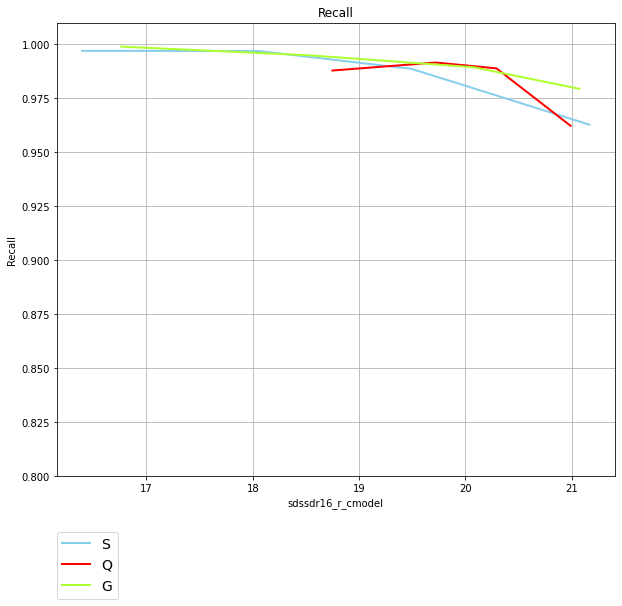

Директория ./plots/gb_on_j уже существует
Директория ./plots/gb_on_j/sdssdr16+psdr2+all_decals8tr уже существует


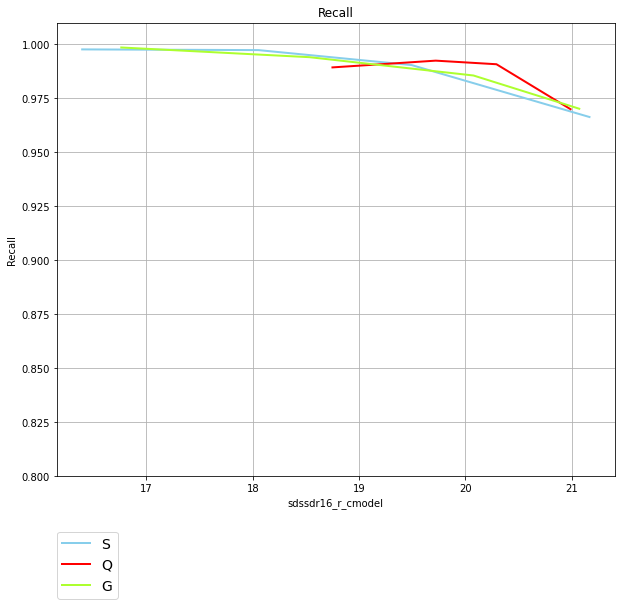

In [37]:
model = 'gb'

for data in ['not_j', 'j']:

    import os
    path = f"./plots/{model}_on_{data}"

    try:
            os.makedirs(path)
    except FileExistsError:
        print("Директория %s уже существует" % path) 
    except OSError:
            print ("Создать директорию %s не удалось" % path)
            exit()

    for overview in ["sdssdr16+psdr2+all_decals8tr"]:#f[data].keys():
        path = f"./plots/{model}_on_{data}/{overview}"
        try:
                os.makedirs(path)
        except FileExistsError:
            print("Директория %s уже существует" % path)
        except OSError:
                print("Создать директорию %s не удалось" % path)
                exit()

        df11 = df1[[column]+f[data][overview]+['class']].dropna()
        df22 = df2[[column]+f[data][overview]+['class']].dropna()



        model1, robust1 = joblib.load('./models0/'+ data +'/model_'+overview+'.pkl'), joblib.load('models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
        model2, robust2 = joblib.load('./models1/'+ data +'/model_'+overview+'.pkl'), joblib.load('models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

        #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
        #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


        #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
        #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

        Recall_plot(df11, df22, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', data=data)



Тест на слабых объектах

Директория ./plots/gb_on_not_j уже существует
Директория ./plots/gb_on_not_j/weak_sdssdr16+psdr2+all_decals8tr уже существует


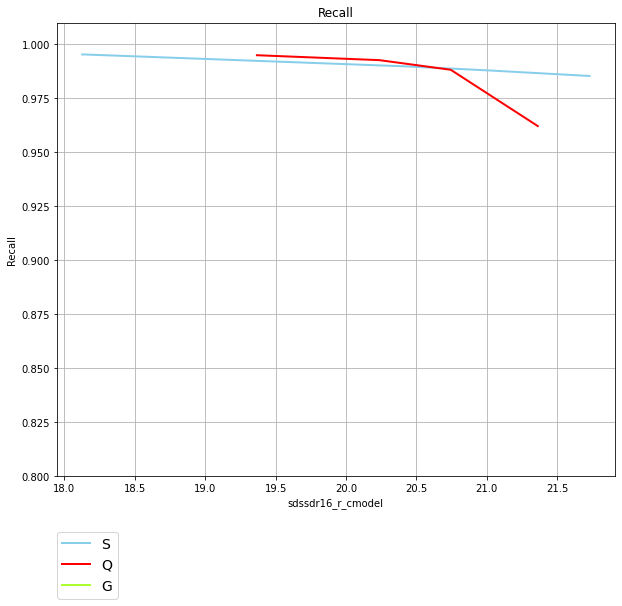

[[0.979 0.021]
 [0.03  0.97 ]]


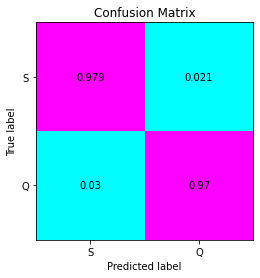

Директория ./plots/gb_on_j уже существует
Директория ./plots/gb_on_j/weak_sdssdr16+psdr2+all_decals8tr уже существует


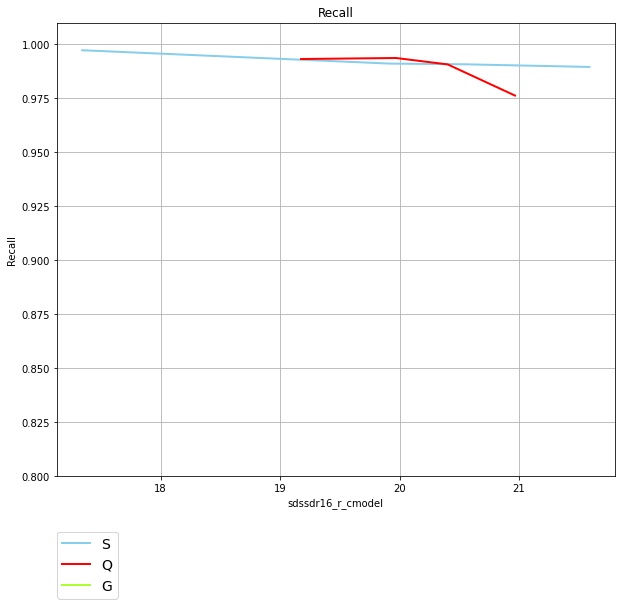

[[0.984 0.016]
 [0.023 0.977]]


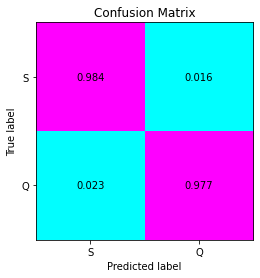

In [68]:
model = 'gb'

for data in ['not_j', 'j']:

    import os
    path = f"./plots/{model}_on_{data}"

    try:
            os.makedirs(path)
    except FileExistsError:
        print("Директория %s уже существует" % path) 
    except OSError:
            print ("Создать директорию %s не удалось" % path)
            exit()

    for overview in ["sdssdr16+psdr2+all_decals8tr"]:#f[data].keys():
        path = f"./plots/{model}_on_{data}/weak_{overview}"
        try:
                os.makedirs(path)
        except FileExistsError:
            print("Директория %s уже существует" % path)
        except OSError:
                print("Создать директорию %s не удалось" % path)
                exit()

        df11 = df1[[column]+f[data][overview]+['class']].dropna()
        df22 = df2[[column]+f[data][overview]+['class']].dropna()



        model1, robust1 = joblib.load('weak/models0/'+ data +'/model_'+overview+'.pkl'), joblib.load('weak/models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
        model2, robust2 = joblib.load('weak/models1/'+ data +'/model_'+overview+'.pkl'), joblib.load('weak/models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

        #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
        #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


        #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
        #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

        Recall_plot(df11, df22, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', data=data)
        Confusion_Matrix(df11, df22, model1, model2, robust1, robust2, column, None, data=data, norm=True)


Директория ./plots/gb_on_not_j уже существует
Директория ./plots/gb_on_not_j/weak_sdssdr16+psdr2+all_decals8tr уже существует


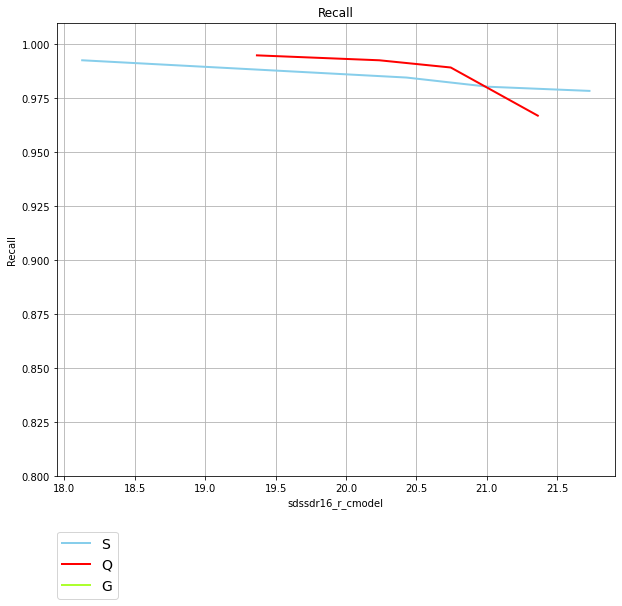

[[0.969 0.03 ]
 [0.027 0.973]]


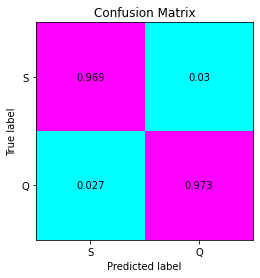

Директория ./plots/gb_on_j уже существует
Директория ./plots/gb_on_j/weak_sdssdr16+psdr2+all_decals8tr уже существует


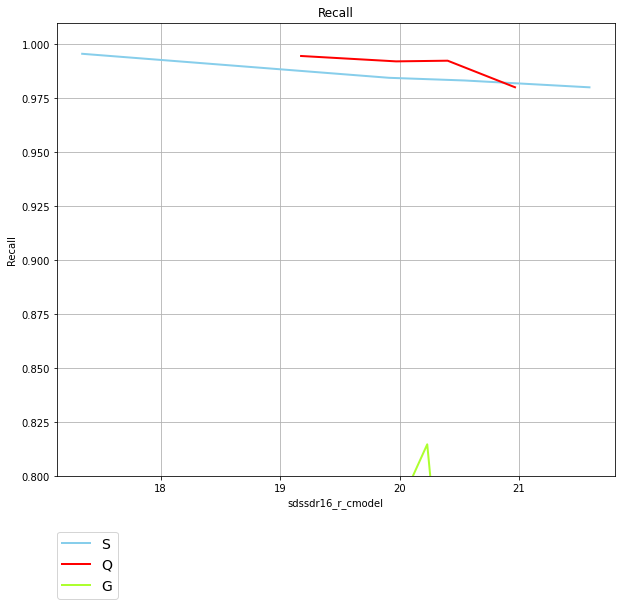

[[0.972 0.027]
 [0.019 0.98 ]]


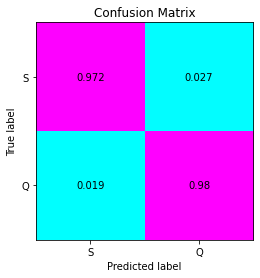

In [69]:
model = 'gb'

for data in ['not_j', 'j']:

    import os
    path = f"./plots/{model}_on_{data}"

    try:
            os.makedirs(path)
    except FileExistsError:
        print("Директория %s уже существует" % path) 
    except OSError:
            print ("Создать директорию %s не удалось" % path)
            exit()

    for overview in ["sdssdr16+psdr2+all_decals8tr"]:#f[data].keys():
        path = f"./plots/{model}_on_{data}/weak_{overview}"
        try:
                os.makedirs(path)
        except FileExistsError:
            print("Директория %s уже существует" % path)
        except OSError:
                print("Создать директорию %s не удалось" % path)
                exit()

        df11 = df1[[column]+f[data][overview]+['class']].dropna()
        df22 = df2[[column]+f[data][overview]+['class']].dropna()



        model1, robust1 = joblib.load('models0/'+ data +'/model_'+overview+'.pkl'), joblib.load('models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
        model2, robust2 = joblib.load('models1/'+ data +'/model_'+overview+'.pkl'), joblib.load('models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

        #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
        #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


        #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
        #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
        #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

        Recall_plot(df11, df22, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', data=data)
        Confusion_Matrix(df11, df22, model1, model2, robust1, robust2, column, None, data=data, norm=True)
        

In [28]:
!ls weak/models1/not_j/

In [25]:
interesno = pd.read_pickle('/home/nmalysheva/pred_for_fold/pred.gz_pkl', compression='gzip')

In [26]:
interesno

,nrow,ra,dec,sdssdr16_r_cmodel,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,...,STAR_decals8tr,QSO_decals8tr,GALAXY_decals8tr,STAR_sdssdr16+psdr2+wise_decals8tr,QSO_sdssdr16+psdr2+wise_decals8tr,GALAXY_sdssdr16+psdr2+wise_decals8tr,STAR_sdssdr16+psdr2+all_decals8tr,QSO_sdssdr16+psdr2+all_decals8tr,GALAXY_sdssdr16+psdr2+all_decals8tr,fold
0,765558,182.850396,48.979910,16.824337,21.455454,20.397562,20.176270,20.017108,19.522008,18.280063,...,0.157054,0.000919,0.842028,0.023671,0.001158,0.975171,0.013124,0.000286,0.986591,0
1,295976,192.616971,27.434890,13.692711,18.601305,16.781441,16.180791,15.854903,15.484326,16.269734,...,0.001000,0.000129,0.998870,0.000850,0.000273,0.998877,0.001288,0.000115,0.998597,0
5,267711,155.117013,37.951053,16.642016,19.744036,18.145850,17.332207,17.088476,16.753079,19.015308,...,0.012383,0.000148,0.987469,0.006323,0.002197,0.991480,0.002499,0.000277,0.997224,0
6,94182,185.510020,10.620819,15.300124,20.341056,19.010524,18.585923,17.817668,17.890224,17.053515,...,0.000610,0.000108,0.999282,0.002122,0.000523,0.997356,0.001930,0.000090,0.997980,0
11,476230,159.861973,5.562852,17.380912,19.755114,18.861927,18.829504,18.670477,18.471404,18.614930,...,0.392609,0.005122,0.602269,0.001984,0.000853,0.997164,0.001404,0.000614,0.997982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94372,694127,4.709113,6.964043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.385812,0.227300,0.386888,0.766296,0.201496,0.032208,0.862332,0.088569,0.049098,1
95296,695047,152.058440,40.935157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.385812,0.227300,0.386888,0.766296,0.201496,0.032208,0.862332,0.088569,0.049098,1
97481,697222,131.258890,41.010657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.998621,0.000725,0.000654,0.991739,0.005533,0.002728,0.998363,0.000221,0.001417,1
98291,698028,154.661450,37.449325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.997542,0.000546,0.001913,0.990555,0.006938,0.002506,0.998093,0.000395,0.001512,1
